# Calculating droplet flow from simulations

# WARNING

To get analytical velocities in `flow_stats_100.csv`, you need to run code in the Julia notebook `Fig_2B-4B.ipynb`. Read the README.md.

In [1]:
import numpy as np
from numpy import cos, sin, exp, pi, sqrt
import pandas as pd
from pathlib import Path
import scipy as sp
from scipy.special import kn
from scipy.integrate import quad, tplquad
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import ast


import scienceplots

cm = 1/2.54

def get_size_inches(frac_x, frac_y):
    prl_col_size = 8.5 * cm
    return [frac_x * prl_col_size, frac_y * 1.0 * prl_col_size]

def rcparams():
    mpl.style.use('default')
    plt.style.use(['science', 'nature'])
    plt.rcParams.update({
        'savefig.format': 'pdf',

        'font.size': 8,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Helvetica',
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
        'text.usetex': False,
        
        'lines.linewidth':1.5,
        
        'figure.figsize': get_size_inches(1, 2/3),

        'xtick.direction': 'out',
        'xtick.top': False,
        'xtick.bottom': True,
        'xtick.minor.visible': False,
        'xtick.labelsize': 8,
        'xtick.minor.size': 2,
        'xtick.minor.width': 0.5,
        'xtick.major.pad': 3,
        'xtick.major.size': 3,
        'xtick.major.width': 1,
        
        'ytick.direction': 'out',
        'ytick.right': False,
        'ytick.left': True,
        'ytick.minor.visible': False,
        'ytick.labelsize': 8,
        'ytick.direction': 'out',
        'ytick.minor.size': 2,
        'ytick.minor.width': 0.5,
        'ytick.major.pad': 3,
        'ytick.major.size': 3,
        'ytick.major.width': 1,

        'axes.grid': False,
        'axes.edgecolor': 'black',
        'axes.facecolor': 'white',
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.titlesize': 8,
        'axes.titlepad': 5,
        'axes.labelsize': 8,
        'axes.linewidth': 1,
        
        'legend.fontsize': 8,
        
        'figure.facecolor': 'white',
        'figure.dpi': 200,
        
        'savefig.transparent': True
    })

rcparams()

In [10]:
simdir = Path('20240224_FlowPhaseDiagramHighRes')

In [3]:
def input_parse(filename):
    """Parse input parameters from file and return them as a dictionary

    Args:
        filename (string): Name of file that contains the input parameters for simulations

    Returns:
        input_parameters (dict): A dictionary that contains (key,value) pairs of (parameter name, parameter value)
    """

    # Initialize dictionary
    input_parameters = {}

    # Check if input parameter file exists
    try:
        open(filename, 'r')
    except IOError:
        print("Could not open input parameter file: " + filename)
        exit()

    # Open and read input parameter file
    with open(filename, 'r') as f:
        for line in f:
            # Remove the \n character from the string
            line = line.strip()
            # If the line is not an empty string, process the line
            if line:
                # If the line is not a comment i.e. does not start with '#', then process the line
                if line.find('#') == -1:
                    # handle lines with more than 1 comma
                    var_name, var_value = line.split(',')[0], ",".join(line.split(',')[1:])
                    # Remove any white spaces in the variable value
                    var_value = var_value.strip()
                    try:
                        input_parameters[var_name] = float(var_value)
                    except ValueError:
                        # This occurs when python cannot convert a string into a float.
                        # Evaluate the python expression as a list
                        input_parameters[var_name] = ast.literal_eval(var_value)

    return input_parameters

In [6]:
simdir = Path('08_FreezeRNA')

In [11]:
for folder in simdir.iterdir():
    if folder.is_dir():
        if (folder/"input_params.txt").is_file() and (folder/"analysis.csv").is_file():
            # Parse params
            param_dict = input_parse(str(folder/"input_params.txt"))
            
            # Read analysis.csv file
            df = pd.read_csv(folder/"analysis.csv", index_col=0).iloc[15:]
            
            # Smooth data
            filter = lambda x: uniform_filter1d(x,20)
            df['smoothed_distance'] = filter(df["center_of_mass"])
            df['smoothed_velocity'] = -np.gradient(filter(df["center_of_mass"]),df["time"])

            # Parameters
            df['Mc'] = param_dict['M1']
            df['Mm'] = param_dict['M2'] * param_dict['lamda_tilde']
            df['Chi'] = param_dict['gamma_tilde']
            df['kp'] = param_dict['k_production']
            df['kd'] = param_dict['k_degradation']
            df['sigma'] = param_dict['reaction_sigma']
            df['alpha'] = np.sqrt(param_dict['k_degradation']/ # 1 over the diffusion length
                                  (param_dict['M2'] * param_dict['lamda_tilde']))
            df['cplus'] = param_dict['c_bar_1'] + np.sqrt(-param_dict['beta_tilde'])
            df['cminus'] = param_dict['c_bar_1'] - np.sqrt(-param_dict['beta_tilde'])
            
            # Save to CSV
            df.to_csv(folder/"flow_stats.csv", index=False)

            #subsample to 100 points along the flow trajectory for numerical integration
            distance_vals = np.linspace(df['smoothed_distance'].min(), df['smoothed_distance'].max(), 100)
            df_sorted = df.sort_values('smoothed_distance', inplace=False)
            df_sorted = df_sorted.reset_index(drop=True)
            inds = np.searchsorted(df_sorted['smoothed_distance'], distance_vals)
            df_sorted.loc[inds].to_csv(folder/"flow_stats_100.csv", index=False)

In [12]:
analysis_file = simdir/"M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.52_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0/analysis.csv"
df = pd.read_csv(analysis_file).iloc[15:]

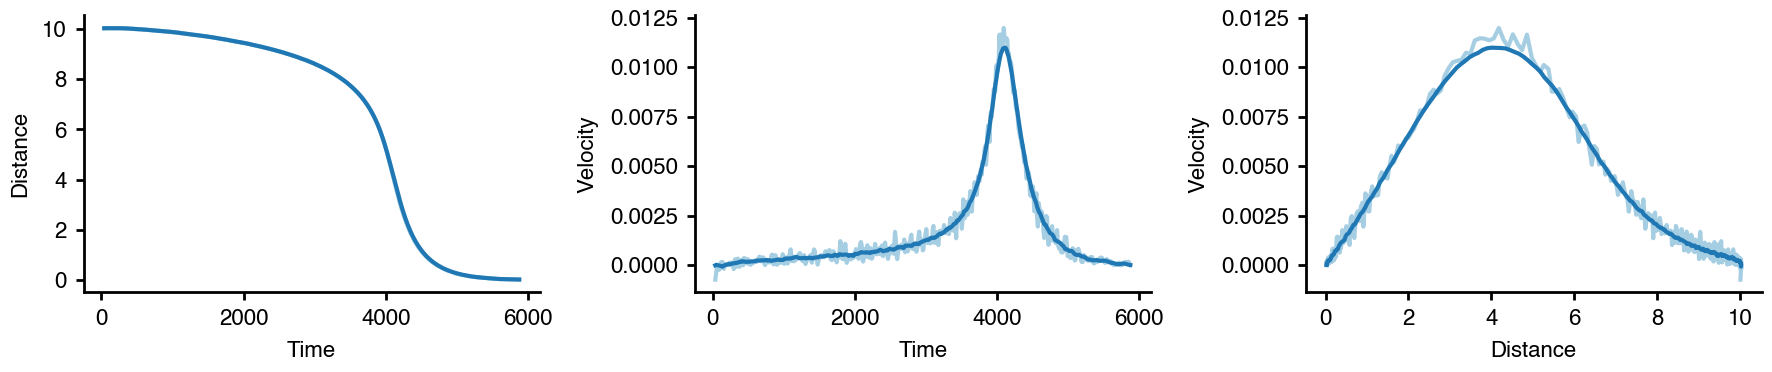

In [13]:
fig, axes = plt.subplots(1,3,figsize=[9, 2])
filter = lambda x: uniform_filter1d(x,20)
cmap = mpl.colormaps["Paired"].colors
# Distance-time plot
ax = axes[0]; ax.set_xlabel("Time"); ax.set_ylabel("Distance")
ax.plot(df["time"],df["center_of_mass"],color=cmap[0])
ax.plot(df["time"],filter(df["center_of_mass"]),color=cmap[1])
# Velocity-time plot
ax = axes[1]; ax.set_xlabel("Time"); ax.set_ylabel("Velocity")
ax.plot(df["time"],-np.gradient(df["center_of_mass"],df["time"]),color=cmap[0])
ax.plot(df["time"],-np.gradient(filter(df["center_of_mass"]),df["time"]),color=cmap[1])
# Velocity-distance plot
ax = axes[2]; ax.set_xlabel("Distance"); ax.set_ylabel("Velocity")
ax.plot(df["center_of_mass"],-np.gradient(df["center_of_mass"],df["time"]),color=cmap[0])
ax.plot(filter(df["center_of_mass"]),-np.gradient(filter(df["center_of_mass"]),df["time"]),color=cmap[1])
fig.tight_layout()

In [ ]:
simdir = Path('20240224_FlowPhaseDiagramHighRes')
fig, ax = plt.subplots(4, 6, figsize=get_size_inches(2,1), sharex=True, sharey=True)
kp_vals = [0.07, 0.08, 0.09, 0.1]; kp_vals.reverse()
cinit_vals = [3.52, 3.53, 3.54, 3.56, 3.57, 3.58]
prefactors = np.zeros((len(kp_vals), len(cinit_vals)))
fstring = ('M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_{kp}_c1_{c1}_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_'
           'kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0')
simtitles = [fstring.format(kp=kp, c1=c1) for kp in kp_vals for c1 in cinit_vals]
for i, simtitle in enumerate(simtitles):
    folder = simdir/simtitle
    row = i // 6; col = i % 6
    
    # Simulations
    df = pd.read_csv(folder/"flow_stats.csv").iloc[15:]
    ax[row, col].plot(df["smoothed_distance"], df["smoothed_velocity"],color="black",linewidth=2)
    
    # Analytical
    flow_stats_df = pd.read_csv(folder/"flow_stats_100.csv")
    ax[row, col].plot(flow_stats_df["smoothed_distance"], flow_stats_df["analytical_velocity"], linestyle="--",linewidth=2)

    # Titles
    kp = flow_stats_df['kp'].values[0]
    cinit = float(str(folder.name).strip().split('_')[13])
    # ax[row, col].set_title(f'$k_p={kp}$, $c_-={cinit}$', size=8)
    
    if col == 0:
        ax[row, col].set_ylabel(f'$k_p={kp}$', fontsize=8)
    if row == 0:
        ax[row, col].set_xlabel(f'$c_{{-}}={cinit}$', fontsize=8)
        ax[row, col].xaxis.set_label_position('top')


i = 0
filter = lambda x: uniform_filter1d(x,400)
# for kp in kp_vals:
#     for c1 in cinit_vals:
#         row = i // 6; col = i % 6
#         df = pd.read_csv(Path("dedalus")/f"kp_{kp:.2f}_cm_{c1:.2f}.csv", index_col=0)
#         ax[row,col].plot(filter(df["com"]),-np.gradient(filter(df["com"]),df["time"]),color=plt.cm.Paired.colors[0],alpha=0.5)
#         i += 1

ax[0,5].legend(["Simulation","Theory"], fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
fig.supxlabel('distance to locus', fontsize=8,y=0.05)
fig.supylabel('velocity', fontsize = 8)
fig.tight_layout(rect=[0.0, 0.0, 1, 1])
fig.savefig("figures/gridvelocity.pdf",dpi=300)

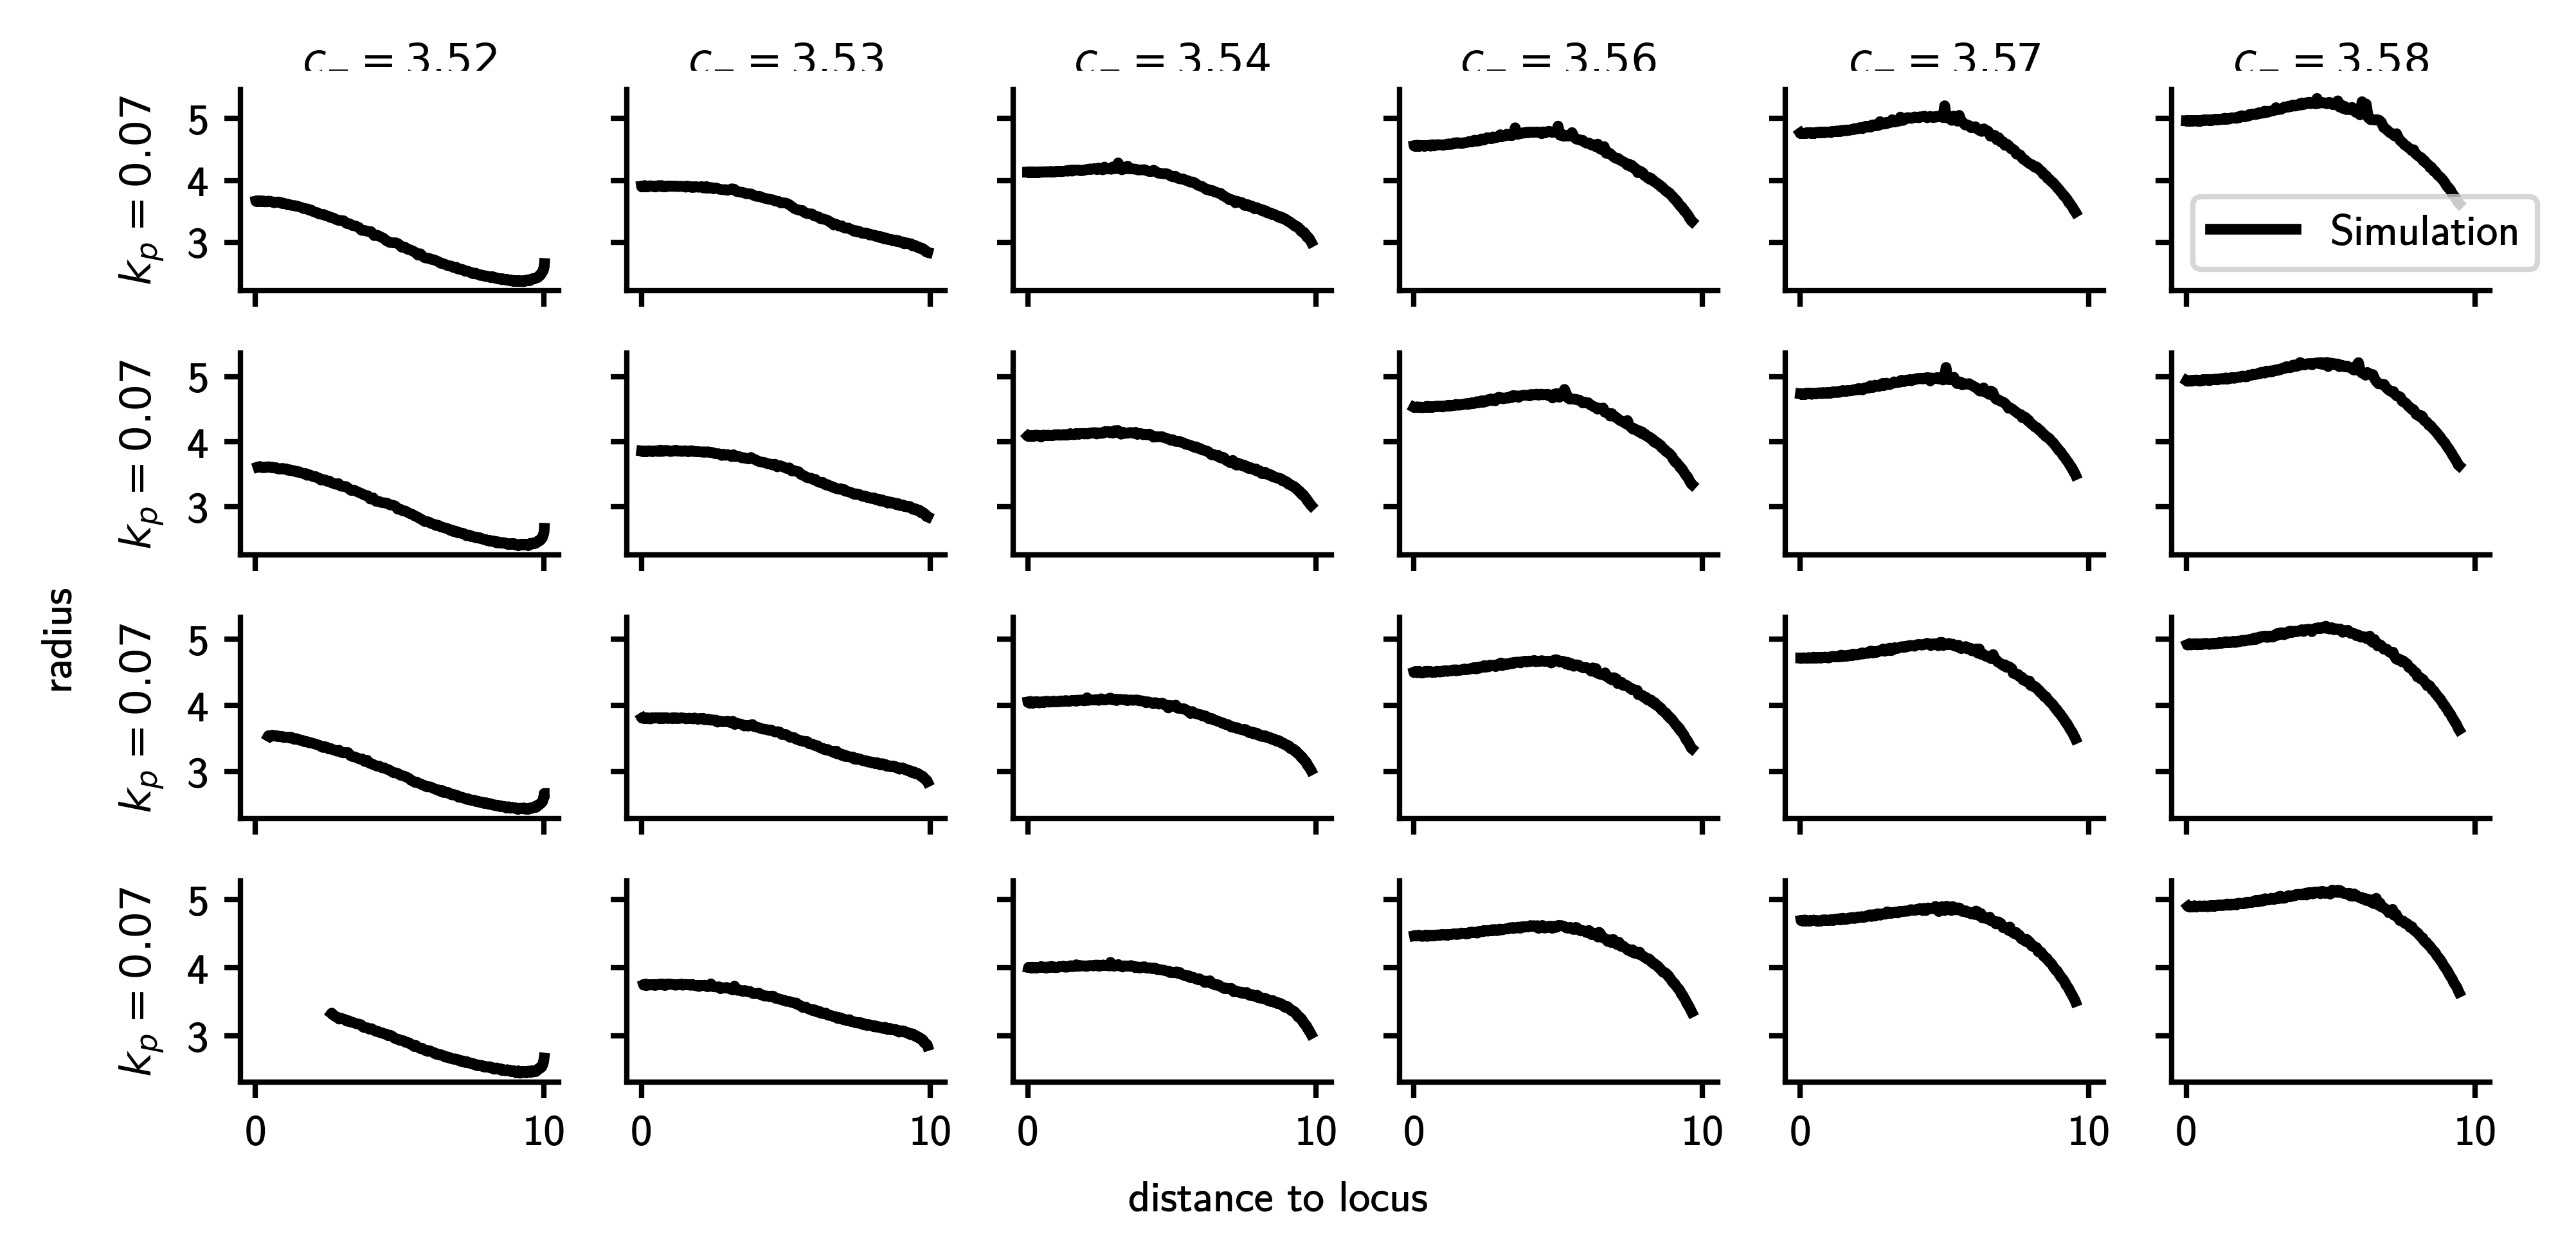

In [16]:
simdir = Path('20240224_FlowPhaseDiagramHighRes')
fig, ax = plt.subplots(4, 6, figsize=get_size_inches(2,1), sharex=True, sharey="row")
kp_vals = [0.07, 0.08, 0.09, 0.1]; kp_vals.reverse()
cinit_vals = [3.52, 3.53, 3.54, 3.56, 3.57, 3.58]
prefactors = np.zeros((len(kp_vals), len(cinit_vals)))
fstring = ('M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_{kp}_c1_{c1}_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_'
           'kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0')
simtitles = [fstring.format(kp=kp, c1=c1) for kp in kp_vals for c1 in cinit_vals]
for i, simtitle in enumerate(simtitles):
    folder = simdir/simtitle
    row = i // 6; col = i % 6
    
    # Simulations
    df = pd.read_csv(folder/"flow_stats.csv").iloc[15:]
    ax[row, col].plot(df["smoothed_distance"], df["mean_radius"],color="black",linewidth=2)
    
    # Titles
    kp = flow_stats_df['kp'].values[0]
    cinit = float(str(folder.name).strip().split('_')[13])
    # ax[row, col].set_title(f'$k_p={kp}$, $c_-={cinit}$', size=8)
    
    if col == 0:
        ax[row, col].set_ylabel(f'$k_p={kp}$', fontsize=8)
    if row == 0:
        ax[row, col].set_xlabel(f'$c_{{-}}={cinit}$', fontsize=8)
        ax[row, col].xaxis.set_label_position('top')


i = 0
filter = lambda x: uniform_filter1d(x,400)

ax[0,5].legend(["Simulation","Theory"], fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
fig.supxlabel('distance to locus', fontsize=8,y=0.05)
fig.supylabel('radius', fontsize = 8)
fig.tight_layout(rect=[0.0, 0.0, 1, 1])
fig.savefig("figures/gridradius.pdf",dpi=300)

In [5]:
kp = 0.08
c1 = 3.53
analysis_file = f"./20240224_FlowPhaseDiagramHighRes/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_{kp}_c1_{c1}_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0/flow_stats_100.csv"
df = pd.read_csv(analysis_file).iloc[:-1]

In [6]:
cmap = mpl.colormaps['Set1']
primary = "black"
secondary = cmap(8)
accent_negative = cmap(0)
accent_positive = cmap(1)

In [7]:
fig, ax = plt.subplots(1,1,figsize=[8.5*1/2*cm, 8.5*1/4*cm])
filter = lambda x: uniform_filter1d(x,20)
# cmap = mpl.colormaps["Paired"].colors
ax.set_xlabel(r"Distance to promoter ($\ell$)")
ax.set_ylabel("Normalized \n"r"velocity")
# simulation = -np.gradient(filter(df["center_of_mass"]),df["time"])
# ax.plot(df["center_of_mass"],-np.gradient(df["center_of_mass"],df["time"]),color=secondary)
ax.plot(df["center_of_mass"],df["smoothed_velocity"]/df["smoothed_velocity"].max(),color=primary,label="Simulation")
ax.plot(df["center_of_mass"],df["analytical_velocity"]/df["analytical_velocity"].max(),color=accent_positive,label="Theory")
ax.legend(handlelength=1,loc="lower center",bbox_to_anchor=[1.4,-0.5])
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,2.5,5,7.5,10])
ax.tick_params(axis='y', labelrotation=0)
plt.savefig("figures/Fig1_F_Velocity")  

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [45]:
df["center_of_mass"][df["smoothed_velocity"].argmax()]/df["center_of_mass"][df["analytical_velocity"].argmax()]

np.float64(1.2705354120843002)

In [49]:
df["aspect"].max()

np.float64(1.5110625387793395)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


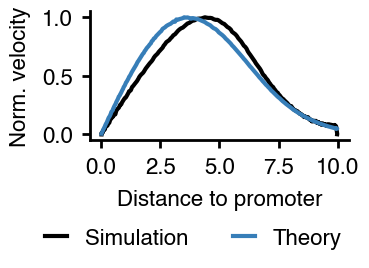

In [79]:
fig, ax = plt.subplots(1,1,figsize=[8.5*1/2*cm, 8.5*1/4*cm])
filter = lambda x: uniform_filter1d(x,20)
# cmap = mpl.colormaps["Paired"].colors
ax.set_xlabel("Distance to promoter")
ax.set_ylabel("Norm. velocity")
# simulation = -np.gradient(filter(df["center_of_mass"]),df["time"])
# ax.plot(df["center_of_mass"],-np.gradient(df["center_of_mass"],df["time"]),color=secondary)
ax.plot(df["center_of_mass"],df["smoothed_velocity"]/df["smoothed_velocity"].max(),color=primary,label="Simulation")
ax.plot(df["center_of_mass"],df["analytical_velocity"]/df["analytical_velocity"].max(),color=accent_positive,label="Theory")
ax.legend(handlelength=1,loc="lower center",bbox_to_anchor=[0.4,-1],ncol=2)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,2.5,5,7.5,10])
plt.savefig("figures/Fig1_F_VelocityAlternative")  